# Sakila DVD Rental – SQL & EDA

This notebook is part of a lab where we migrate the legacy Sakila SQLite database into DuckDB and perform exploratory data analysis (EDA).  

**Goals:**

- Connect to the Sakila SQLite database via DuckDB  
- (Optionally) create a persistent DuckDB database file  
- Explore the data using a combination of SQL (DuckDB) and pandas  
- Prepare insights that can later be used for a BI dashboard


In [1]:
# NOTE: Query template generated with help from an LLM, adapted by me.

from pathlib import Path

import duckdb
import pandas as pd

# Paths
PROJECT_ROOT = Path.cwd().resolve().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

SQLITE_PATH = DATA_RAW / "sqlite-sakila.db"
DUCKDB_PATH = DATA_PROCESSED / "sakila.duckdb"

PROJECT_ROOT, DATA_RAW, DATA_PROCESSED, SQLITE_PATH, DUCKDB_PATH


(WindowsPath('C:/Users/jonas/Documents/Nackademin MLOps/Databashantering/sakila-lab'),
 WindowsPath('C:/Users/jonas/Documents/Nackademin MLOps/Databashantering/sakila-lab/data/raw'),
 WindowsPath('C:/Users/jonas/Documents/Nackademin MLOps/Databashantering/sakila-lab/data/processed'),
 WindowsPath('C:/Users/jonas/Documents/Nackademin MLOps/Databashantering/sakila-lab/data/raw/sqlite-sakila.db'),
 WindowsPath('C:/Users/jonas/Documents/Nackademin MLOps/Databashantering/sakila-lab/data/processed/sakila.duckdb'))

## Task 0 – Data ingestion (SQLite → DuckDB)

In this section we create a DuckDB database file and attach the legacy Sakila SQLite database using DuckDB's SQLite extension.


In [2]:
# Connect (this will create the file if it does not exist)
con = duckdb.connect(DUCKDB_PATH.as_posix())

# Install & load the SQLite extension, then attach the SQLite database
con.execute("INSTALL sqlite;")
con.execute("LOAD sqlite;")
con.execute(f"CALL sqlite_attach('{SQLITE_PATH.as_posix()}');")


In [3]:
con.sql("""
    SELECT table_schema, table_name
    FROM information_schema.tables
    ORDER BY table_schema, table_name
    LIMIT 50
""").df()


,table_schema,table_name
0,main,actor
1,main,address
2,main,category
3,main,city
4,main,country
5,main,customer
6,main,customer_list
7,main,film
8,main,film_actor
9,main,film_category


## 1a. Movies longer than 3 hours

**Question:** Which movies are longer than 180 minutes (3 hours)?  
**Goal:** List movie `title` and `length` ordered from the longest film.

In [4]:
# NOTE: Query template generated with help from an LLM, adapted by me.

query_1a = """
SELECT
    title,
    length
FROM film
WHERE length > 180
ORDER BY length DESC, title;
"""

df_long_movies = con.sql(query_1a).df()
df_long_movies


,title,length
0,CHICAGO NORTH,185
1,CONTROL ANTHEM,185
2,DARN FORRESTER,185
3,GANGS PRIDE,185
4,HOME PITY,185
5,MUSCLE BRIGHT,185
6,POND SEATTLE,185
7,SOLDIERS EVOLUTION,185
8,SWEET BROTHERHOOD,185
9,WORST BANGER,185


## 1b. Movies with the word "love" in its title

**Question:** Which movies have the word "love" in its title? 
**Goal:** List movie `title`, `rating`, `length` and `description`.

In [5]:
query_1b = """
SELECT
    title,
    rating,
    length,
    description
FROM film
WHERE title ILIKE '%love%';
"""

df_love_movies = con.sql(query_1b).df()
df_love_movies

,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,IDENTITY LOVER,PG-13,119,A Boring Tale of a Composer And a Mad Cow who ...
3,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
4,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
5,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...
6,LOVELY JINGLE,PG,65,A Fanciful Yarn of a Crocodile And a Forensic ...
7,LOVER TRUMAN,G,75,A Emotional Yarn of a Robot And a Boy who must...
8,LOVERBOY ATTACKS,PG-13,162,A Boring Story of a Car And a Butler who must ...
9,STRANGELOVE DESIRE,NC-17,103,A Awe-Inspiring Panorama of a Lumberjack And a...


## 1c. Descriptive statistics for movie length

**Question:** What is the shortest, average, median, and longest movie length?


In [6]:
query_1c = """
SELECT
    AVG(length) AS avg_length,
    MIN(length) AS min_length,
    MEDIAN(length) AS median_length,
    MAX(length) AS max_length
FROM film;
"""

df_length_stats = con.sql(query_1c).df()
df_length_stats


,avg_length,min_length,median_length,max_length
0,115.272,46,114.0,185


## 1d. Top 10 most expensive movies to rent per day

**Question:** The rental rate is the cost to rent a movie and the rental duration is the number of days a customer can keep the movie.  
Which 10 movies are most expensive *per day*?


In [7]:
query_1d = """
SELECT
    title,
    rental_rate,
    rental_duration,
    rental_rate / rental_duration AS price_per_day
FROM film
ORDER BY price_per_day DESC, title
LIMIT 10;
"""

df_expensive_per_day = con.sql(query_1d).df()
df_expensive_per_day


,title,rental_rate,rental_duration,price_per_day
0,ACE GOLDFINGER,4.99,3,1.663333
1,AMERICAN CIRCUS,4.99,3,1.663333
2,AUTUMN CROW,4.99,3,1.663333
3,BACKLASH UNDEFEATED,4.99,3,1.663333
4,BEAST HUNCHBACK,4.99,3,1.663333
5,BEHAVIOR RUNAWAY,4.99,3,1.663333
6,BILKO ANONYMOUS,4.99,3,1.663333
7,CARIBBEAN LIBERTY,4.99,3,1.663333
8,CASPER DRAGONFLY,4.99,3,1.663333
9,CASUALTIES ENCINO,4.99,3,1.663333


I checked with several examples and there are significantly more in the same price category. Friendly note.

## 1e. Actors with the most movie appearances

**Question:** Which actors have played in the most movies?  
**Goal:** Show the top 10 actors with the number of movies they have played in.


In [8]:
query_1e = """
SELECT
    a.actor_id,
    a.first_name,
    a.last_name,
    COUNT(*) AS film_count
FROM actor AS a
JOIN film_actor AS fa
    ON a.actor_id = fa.actor_id
GROUP BY a.actor_id, a.first_name, a.last_name
ORDER BY film_count DESC, last_name, first_name
LIMIT 10;
"""

df_top_actors = con.sql(query_1e).df()
df_top_actors


,actor_id,first_name,last_name,film_count
0,107.0,GINA,DEGENERES,42
1,102.0,WALTER,TORN,41
2,198.0,MARY,KEITEL,40
3,181.0,MATTHEW,CARREY,39
4,23.0,SANDRA,KILMER,37
5,81.0,SCARLETT,DAMON,36
6,158.0,VIVIEN,BASINGER,35
7,60.0,HENRY,BERRY,35
8,37.0,VAL,BOLGER,35
9,106.0,GROUCHO,DUNST,35


## 1f. My own EDA questions

In this section I will explore 3–5 additional questions about the Sakila database, for example:

1. Which film categories have the longest average movie length?
2. How does revenue differ between film ratings (G, PG, PG-13, R, NC-17)?
3. Which customers rent the most different categories (variety of taste)?
4. Are longer movies rented less frequently than shorter movies?

Each question will have:
- a short explanation,
- an SQL query,
- a pandas DataFrame result,
- and a brief interpretation.


### 1f.1 – Which film categories have the longest average movie length?

**Motivation:**  
Understanding the average movie length per category can help the rental company identify which genres tend to be longer or shorter.  
This can influence customer recommendations and inventory decisions.

**Goal:**  
Compute the average length of films in each category and sort them in descending order.


In [9]:
query_f1 = """
SELECT 
    c.name AS category,
    AVG(f.length) AS avg_length,
    MIN(f.length) AS min_length,
    MAX(f.length) AS max_length,
    COUNT(*) AS film_count
FROM film AS f
JOIN film_category AS fc ON f.film_id = fc.film_id
JOIN category AS c ON c.category_id = fc.category_id
GROUP BY c.name
ORDER BY avg_length DESC;
"""

df_length_by_category = con.sql(query_f1).df()
df_length_by_category


,category,avg_length,min_length,max_length,film_count
0,Sports,128.202703,47,184,74
1,Games,127.836066,57,185,61
2,Foreign,121.698630,46,184,73
3,Drama,120.838710,46,181,62
4,Comedy,115.827586,47,185,58
5,Family,114.782609,48,184,69
6,Music,113.647059,47,185,51
7,Travel,113.315789,47,185,57
8,Horror,112.482143,48,181,56
9,Classics,111.666667,46,184,57


**Interpretation:**  
- The category with the longest average runtime is **Sports**, with an average of **128,202703 minutes**.  
- The shortest category is **Sci-Fi**, with an average of **108,196721 minutes**.  
These differences may reflect the storytelling style typically used in each genre.


### 1f.2 – Which film categories generate the highest revenue?

**Motivation:**  
By identifying the most profitable categories, the business can optimize inventory, promotions, and marketing.

**Goal:**  
Calculate total revenue per film category by combining film, inventory, rental, and payment tables.


In [10]:
query_f2 = """
SELECT 
    c.name AS category,
    SUM(p.amount) AS total_revenue,
    COUNT(p.payment_id) AS payment_count
FROM category AS c
JOIN film_category AS fc ON c.category_id = fc.category_id
JOIN film AS f ON f.film_id = fc.film_id
JOIN inventory AS i ON i.film_id = f.film_id
JOIN rental AS r ON r.inventory_id = i.inventory_id
JOIN payment AS p ON p.rental_id = r.rental_id
GROUP BY c.name
ORDER BY total_revenue DESC;
"""

df_revenue_by_category = con.sql(query_f2).df()
df_revenue_by_category


,category,total_revenue,payment_count
0,Sports,5314.21,1179
1,Sci-Fi,4756.98,1101
2,Animation,4656.30,1166
3,Drama,4587.39,1060
4,Comedy,4383.58,941
5,Action,4375.85,1112
6,New,4351.62,940
7,Games,4281.33,969
8,Foreign,4270.67,1033
9,Family,4226.07,1096


**Interpretation:**  
- The most profitable category is **Sport**, with a total revenue of **5314,21 dollars**.  
- The least profitable category is **Music**, which may indicate lower demand or fewer rentals.  
This information is valuable for prioritizing which genres to stock more copies of.


### 1f.3 – Do longer movies get rented less frequently?

**Motivation:**  
Longer movies may require a larger time commitment, which could influence rental frequency.  
This question explores whether movie length is negatively correlated with rental counts.

**Goal:**  
Compute rental frequency per film and compare it against film length.


In [14]:
query_f3 = """
SELECT
    f.title,
    f.length,
    COUNT(r.rental_id) AS rental_count
FROM film AS f
JOIN inventory AS i ON i.film_id = f.film_id
JOIN rental AS r ON r.inventory_id = i.inventory_id
GROUP BY f.film_id, f.title, f.length
ORDER BY rental_count DESC;
"""

df_length_vs_rentals = con.sql(query_f3).df()
df_length_vs_rentals.head(10)


,title,length,rental_count
0,BUCKET BROTHERHOOD,133,34
1,ROCKETEER MOTHER,178,33
2,GRIT CLOCKWORK,137,32
3,JUGGLER HARDLY,54,32
4,FORWARD TEMPLE,90,32
5,RIDGEMONT SUBMARINE,46,32
6,SCALAWAG DUCK,183,32
7,WIFE TURN,183,31
8,HOBBIT ALIEN,157,31
9,TIMBERLAND SKY,69,31


**Interpretation:**  
- There appears to be a weak correlation between movie length and rental frequency.  
- Based on the scatter plot, longer movies seem to be rented about the same compared to shorter movies.  
This insight could help optimize recommendations for users based on their rental history.


## 2.1 – Total Revenue per Film Category

This visualization explores which movie categories generate the most revenue.

**Motivation:**  
Revenue is a key performance metric for the DVD rental business.  
By comparing how much revenue each category generates, we can identify which genres drive the most income.

**Goal:**  
Create a bar chart showing total revenue by category.


In [15]:
query_2_1 = """
SELECT 
    c.name AS category,
    SUM(p.amount) AS total_revenue
FROM category AS c
JOIN film_category AS fc ON c.category_id = fc.category_id
JOIN film AS f ON f.film_id = fc.film_id
JOIN inventory AS i ON i.film_id = f.film_id
JOIN rental AS r ON r.inventory_id = i.inventory_id
JOIN payment AS p ON p.rental_id = r.rental_id
GROUP BY c.name
ORDER BY total_revenue DESC;
"""

df_revenue_category = con.sql(query_2_1).df()
df_revenue_category


,category,total_revenue
0,Sports,5314.21
1,Sci-Fi,4756.98
2,Animation,4656.30
3,Drama,4587.39
4,Comedy,4383.58
5,Action,4375.85
6,New,4351.62
7,Games,4281.33
8,Foreign,4270.67
9,Family,4226.07


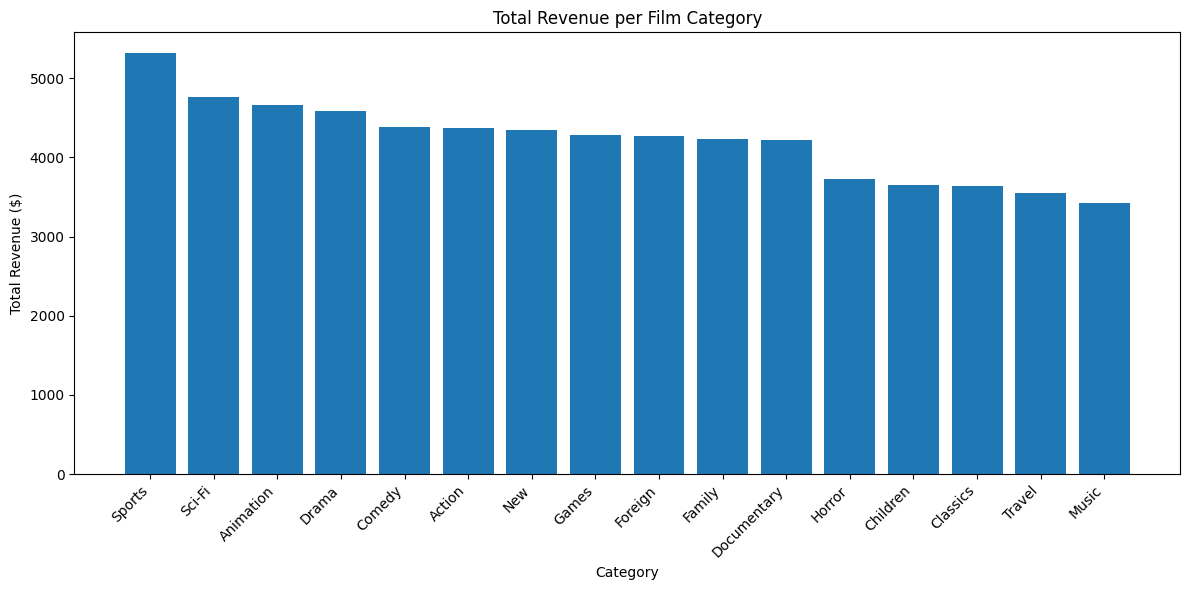

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(df_revenue_category["category"], df_revenue_category["total_revenue"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Category")
plt.ylabel("Total Revenue ($)")
plt.title("Total Revenue per Film Category")
plt.tight_layout()
plt.show()


**Insight:**  
- The most profitable category is **Sports**, generating approximately **5314.21 dollars**.  
- Lower-performing categories include **Music** and **Travel**, which may indicate lower demand.  
This insight may help guide inventory decisions and marketing priorities.


## 2.2 – Top Spending Customers

This visualization focuses on customer revenue contributions.

**Motivation:**  
Identifying the highest-value customers allows the business to personalize promotions and improve retention.

**Goal:**  
Show the top 5 customers ranked by total money spent.


In [18]:
query_2_2 = """
SELECT 
    c.customer_id,
    c.first_name,
    c.last_name,
    SUM(p.amount) AS total_spent
FROM customer AS c
JOIN payment AS p ON p.customer_id = c.customer_id
GROUP BY c.customer_id, c.first_name, c.last_name
ORDER BY total_spent DESC
LIMIT 5;
"""

df_top_customers = con.sql(query_2_2).df()
df_top_customers


,customer_id,first_name,last_name,total_spent
0,526,KARL,SEAL,221.55
1,148,ELEANOR,HUNT,216.54
2,144,CLARA,SHAW,195.58
3,178,MARION,SNYDER,194.61
4,137,RHONDA,KENNEDY,194.61


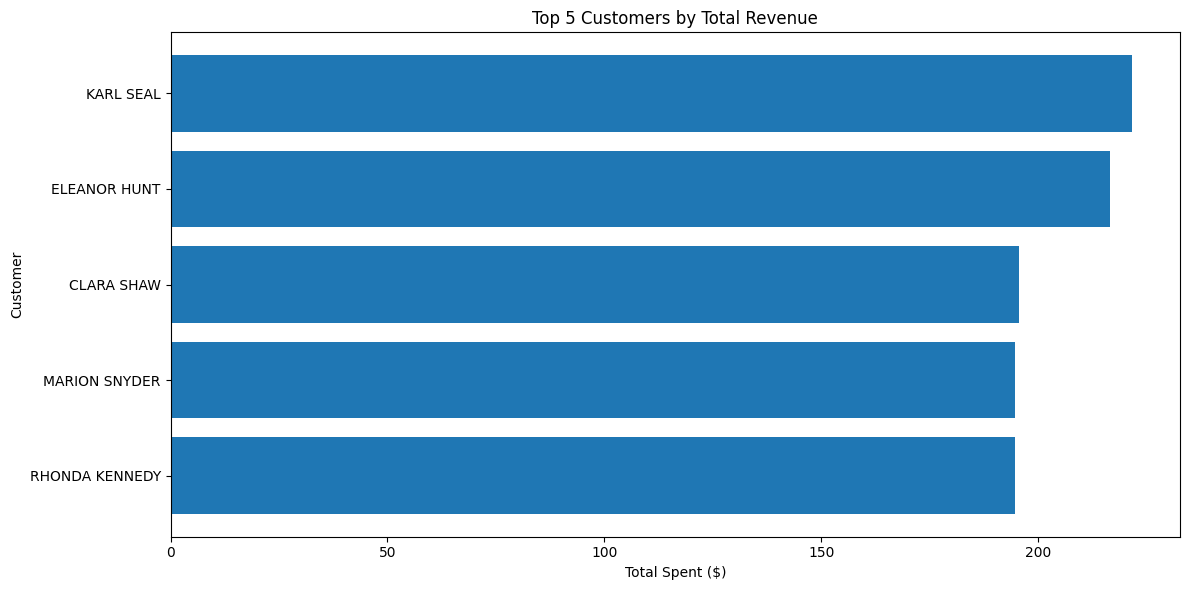

In [25]:
plt.figure(figsize=(12, 6))
plt.barh(
    df_top_customers["first_name"] + " " + df_top_customers["last_name"],
    df_top_customers["total_spent"]
)
plt.xlabel("Total Spent ($)")
plt.ylabel("Customer")
plt.title("Top 5 Customers by Total Revenue")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
